In [1]:
from keras import layers,optimizers,models,losses
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Activation
from keras import utils
from tensorflow import keras
from keras.utils import get_custom_objects
from keras import metrics
from keras import utils
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-02 16:28:58.415658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 16:28:58.415783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 16:28:58.545974: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_datagen = keras.utils.image_dataset_from_directory(
        '/kaggle/input/endoscopy-data/Dataset/training',
        labels = 'inferred',
        label_mode='categorical',
        color_mode='rgb',
        class_names=['Angioectasia','Bleeding','Erosion','Erythema',
                    'Foreign Body','Lymphangiectasia','Normal','Polyp',
                    'Ulcer','Worms'],
        batch_size=32,
        image_size=(224,224))


Found 37607 files belonging to 10 classes.


In [3]:
val_datagen = keras.utils.image_dataset_from_directory(
        '/kaggle/input/endoscopy-data/Dataset/validation',
        labels = 'inferred',
        label_mode='categorical',
        color_mode='rgb',
        class_names=['Angioectasia','Bleeding','Erosion','Erythema',
                    'Foreign Body','Lymphangiectasia','Normal','Polyp',
                    'Ulcer','Worms'],
        batch_size=32,
        image_size=(224,224))

Found 16132 files belonging to 10 classes.


In [4]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    ip = layers.Input(shape=(224,224,3))
    norm = layers.Rescaling(scale=1./255,trainable=False)(ip)
    x = layers.Conv2D(64,3,strides=1,padding='same',activation='relu')(norm)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2)(x)
    x = layers.Conv2D(64,3,strides=1,padding='same',activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2)(x)
    x = layers.Conv2D(128,3,strides=1,padding='same',activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2)(x)
    x = layers.Conv2D(256,5,strides=1,padding='same',activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64,7,strides=1,padding='same',activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2),strides=2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(100,activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    op = layers.Dense(10,activation='softmax')(x)
    model = models.Model(ip,op)
    model.compile(optimizer=optimizers.SGD(),loss='categorical_crossentropy',metrics=['accuracy',metrics.Precision(),metrics.Recall()])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       313,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049,624 (7.82 MB)

 Trainable params: 2,049,622 (7.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

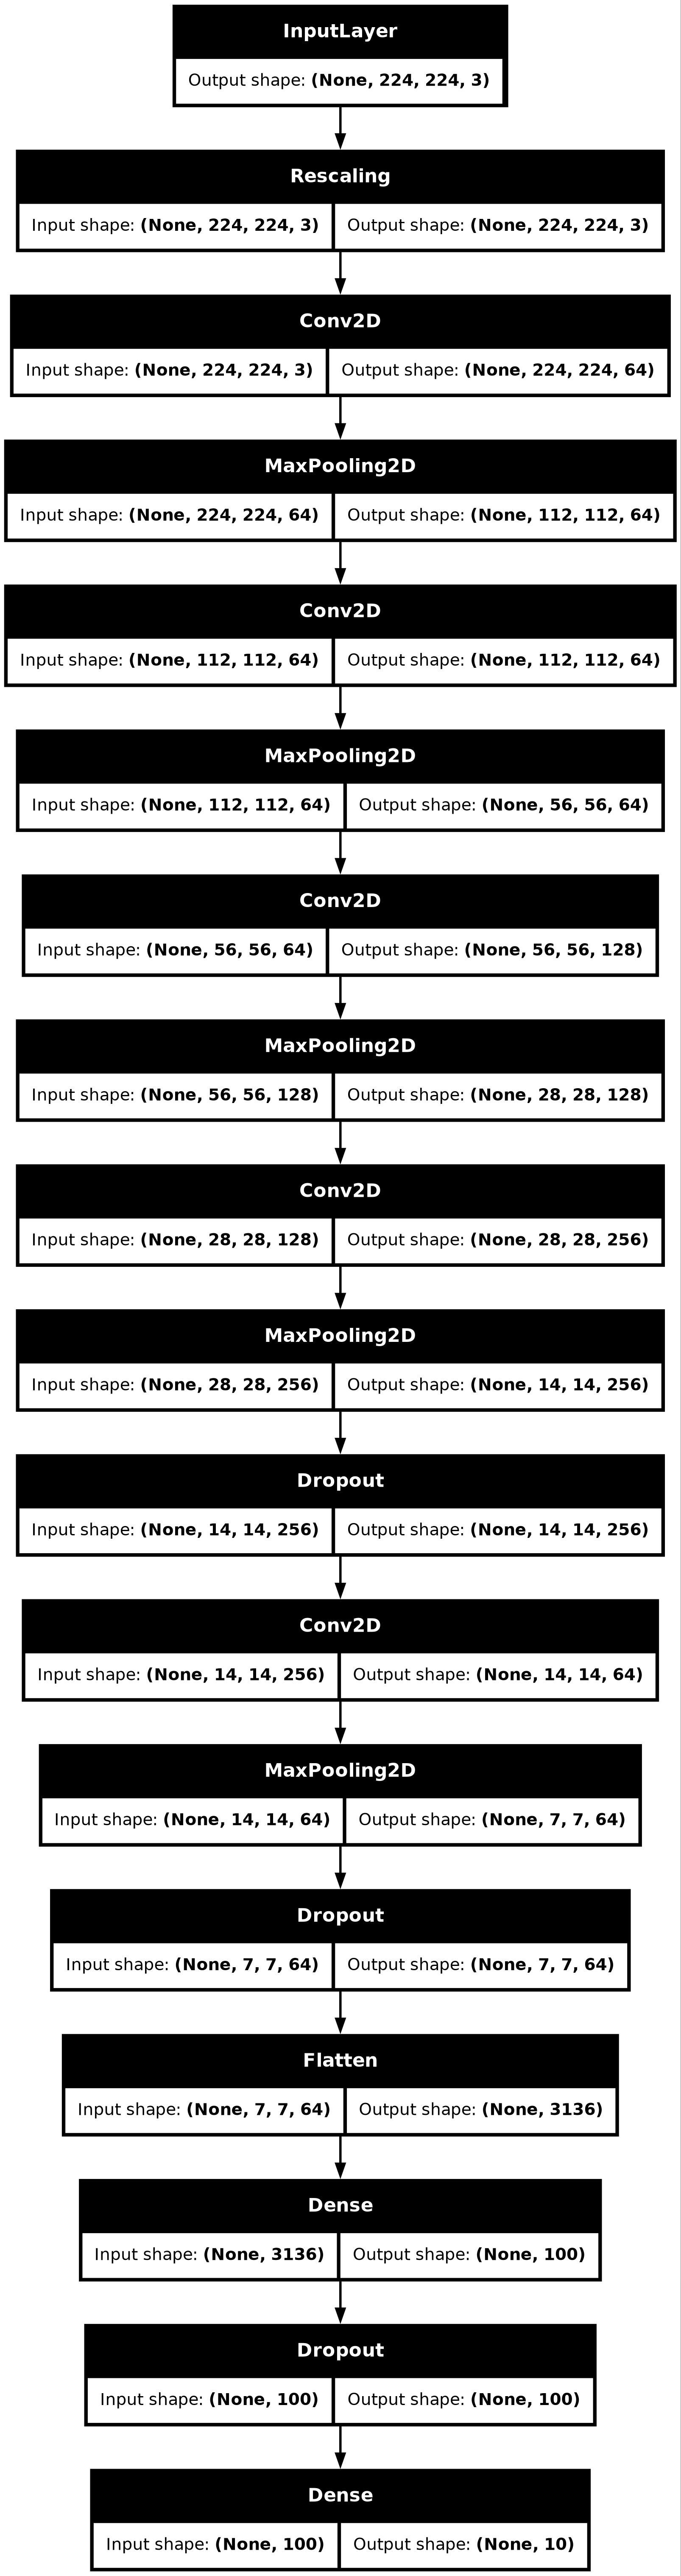

In [5]:
utils.plot_model(model,'/kaggle/working/model.jpg',show_shapes=True)

In [6]:
from keras.callbacks import EarlyStopping


In [7]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    restore_best_weights=True,
    mode='max'
)


In [8]:
history = model.fit(train_datagen,validation_data=(val_datagen),epochs=5,callbacks=[early_stopping])

Epoch 1/5


2024-11-02 16:30:43.368011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/cond/else/_102/cond/StatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 151s 121ms/step - accuracy: 0.9521 - loss: 0.1334 - precision: 0.9626 - recall: 0.9434 - val_accuracy: 0.8768 - val_loss: 0.4878 - val_precision: 0.8989 - val_recall: 0.8649
Epoch 2/5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 135s 114ms/step - accuracy: 0.9482 - loss: 0.1392 - precision: 0.9614 - recall: 0.9380 - val_accuracy: 0.8750 - val_loss: 0.4451 - val_precision: 0.9037 - val_recall: 0.8609
Epoch 3/5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 135s 115ms/step - accuracy: 0.9515 - loss: 0.1355 - precision: 0.9630 - recall: 0.9412 - val_accuracy: 0.8753 - val_loss: 0.4556 - val_precision: 0.9039 - val_recall: 0.8593
Epoch 4/5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 135s 114ms/step - accuracy: 0.9534 - loss: 0.1315 - precision: 0.9633 - recall: 0.9433 - val_accuracy: 0.8735 - val_loss: 0.4986 - val_precision: 0.8928 - val_recall: 0.8623
Epoch 5/5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 134s 114ms/step - accuracy: 0.9527 - loss: 0.1327 - precision: 0.9627 - recall: 0.9432 - val_accuracy: 0.8790

In [9]:
training_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(training_acc,val_acc)

[0.9494256377220154, 0.948415219783783, 0.9501169919967651, 0.9507551789283752, 0.9513933062553406] [0.8767666816711426, 0.8750309944152832, 0.8752789497375488, 0.8735432624816895, 0.8789982795715332]


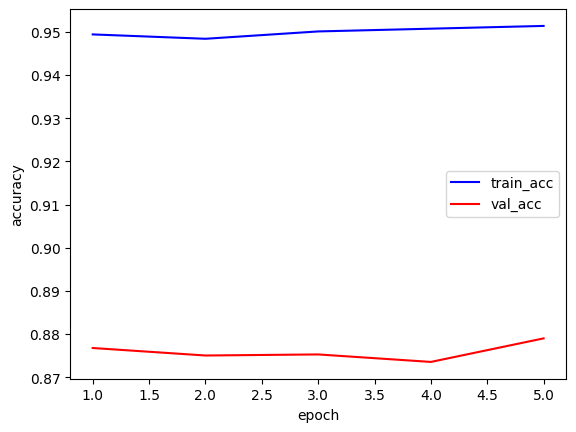

In [11]:
epoch = range(1,len(val_acc)+1)
plt.plot(epoch, training_acc, color='blue',label='train_acc')
plt.plot(epoch , val_acc, color='red',label='val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [12]:
model.save('endo.keras')

In [ ]:
test_data_dir = '/kaggle/input/test-dataset/Testing set/Images'
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema',
               'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp',
               'Ulcer', 'Worms']

results = {
    'filename': [],
    'predicted_class': [] 
}
i=0
for filename in os.listdir(test_data_dir):
    i+=1
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_data_dir, filename)
        img = load_img(img_path, target_size=(224, 224))
        img_array = np.expand_dims(img, axis=0) 

        prediction = model.predict(img_array,verbose=0)
        predicted_class = np.argmax(prediction, axis=1)
        results['filename'].append(filename)
        for i, class_name in enumerate(class_names):
            results[class_name] = results.get(class_name, []) + [prediction[0][i]]
        results['predicted_class'].append(class_names[predicted_class[0]])
    if i % 200 == 0:
        print(f"Processed {i} files...")
results_df = pd.DataFrame(results)
output_file = 'predictions2.xlsx'
results_df.to_excel(output_file, index=False)

print(f"Predictions saved to {output_file}")

W0000 00:00:1730565731.195177      34 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 3 } dim { size: 224 } dim { size: 224 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 3 } dim { size: 64 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12020" } environment { key: "cudnn" value: "8904" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipr

In [ ]:
def get_predictions(dataset, model, class_names):
    predictions = []
    filenames = []
    
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        for i in range(len(images)):
            filename = os.path.basename(dataset.file_paths[i])  # Get the corresponding file name
            score = preds[i]
            predicted_class_index = np.argmax(score)
            predicted_class_name = class_names[predicted_class_index]  # Get the class name
            predictions.append([filename] + score.tolist() + [predicted_class_name])  # Use class name here
            filenames.append(filename)

    return predictions

# Collect predictions for training data
train_predictions = get_predictions(train_datagen, model, class_names)
train_df = pd.DataFrame(train_predictions, columns=['Filename'] + class_names + ['Predicted Class'])
train_df.to_excel('train_predictions2.xlsx', index=False)

# Collect predictions for validation data
val_predictions = get_predictions(val_datagen, model, class_names)
val_df = pd.DataFrame(val_predictions, columns=['Filename'] + class_names + ['Predicted Class'])
val_df.to_excel('val_predictions2.xlsx', index=False)

print("Prediction files created successfully.")
